<h4>Global CO<sub>2</sub> Emissions Dataset from Maven Analytics</h4>

<p>Objectives:</p>
<ul>
<li>What is the trend of CO<sub>2</sub> emissions in the world over time?</li>
    <li> Can it be related to the demographics?</li>
    <li>Which country contributes both the least and the most emissions?</li>
    <li>What are the major sources of these emissions? </li>
    </ul>

In [38]:
 #Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [39]:
df = pd.read_csv("data/co2_data.csv")
df.shape

(50598, 79)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50598 entries, 0 to 50597
Data columns (total 79 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   country                                    50598 non-null  object 
 1   year                                       50598 non-null  int64  
 2   iso_code                                   42142 non-null  object 
 3   population                                 40008 non-null  float64
 4   gdp                                        14564 non-null  float64
 5   cement_co2                                 24974 non-null  float64
 6   cement_co2_per_capita                      22714 non-null  float64
 7   co2                                        31349 non-null  float64
 8   co2_growth_abs                             29010 non-null  float64
 9   co2_growth_prct                            25032 non-null  float64
 10  co2_including_luc     

In [41]:
#Columns containing demographics and CO2 emissions
df_demographics = df[['country','iso_code','year', 'population', 'gdp','co2',\
    'land_use_change_co2']]

# Columns containing the sources of emissions
df_sources = df[['cement_co2','coal_co2','flaring_co2','gas_co2','land_use_change_co2',
    'consumption_co2','oil_co2','other_industry_co2']]

# Columns containing temperature changes
df_temp = df[[col for col in df.columns if 'temperature' in col]]
df_temp = pd.concat([df_temp, df[['country','iso_code']]], axis=1)

#Columns for the methane and NOx
df_chem = df[['country','iso_code','year','methane','nitrous_oxide']]

<h3>Table 1: Sources Table</h3>

In [42]:
# By pd.melt, reverse the columns into rows and maintain the values
df_sources =pd.melt(df_sources.reset_index(),id_vars=['index'],value_vars=df_sources.columns, \
    var_name="emission_sources",value_name="million_tons").copy()

df_sources = df_sources.groupby('emission_sources')['million_tons'].sum().reset_index()
df_sources.shape

(8, 2)

In [43]:
# Adding the Percentage Column
df_sources['percentage'] = (df_sources['million_tons']/df_sources['million_tons'].sum())*100
df_sources['percentage'] = df_sources['percentage'].apply \
    (lambda x: round(x,0) if x > 1 else round(x,2))
df_sources

,emission_sources,million_tons,percentage
0,cement_co2,209594.066,1.00
1,coal_co2,3870596.153,21.00
2,consumption_co2,6073187.268,33.00
3,flaring_co2,86909.154,0.47
4,gas_co2,1249162.183,7.00
5,land_use_change_co2,4333960.833,23.00
6,oil_co2,2789318.374,15.00
7,other_industry_co2,43974.095,0.24


<h3> Table 2: Grouping By Country</h3>
<p>based on checking the dataset structure, the rows represents by the categorical country per parameters of CO<sub>2</sub>. I will take the mean value of the emissions to compress the dataset, and simplify its findings. </p>

In [44]:
# Set country as index
df_demographics.set_index(["country"], inplace=True)

# Column with values to maintain
demographics_values = ["population","gdp","co2","land_use_change_co2"]
df_demo_country = df_demographics.groupby(["country","iso_code"]) \
     [demographics_values].mean()
df_demo_country.reset_index(inplace=True)
df_demo_country.shape


(232, 6)

In [45]:
# Rename co2 column based on the data definition
df_demo_country = df_demo_country.rename(columns={"co2":"co2 without land_use",\
    "index":"id"})

# Include land use change for calculations
df_demo_country['co2'] = df_demo_country['co2 without land_use'] + \
     df_demo_country['land_use_change_co2']

# Dropping unnecessary columns
df_demo_country = df_demo_country.drop(['land_use_change_co2'],axis=1).copy()
df_demo_country.head()


,country,iso_code,population,gdp,co2 without land_use,co2
0,Afghanistan,AFG,1.018891e+07,2.146437e+10,2.986219,7.992667
1,Aland Islands,ALA,NaN,NaN,NaN,NaN
2,Albania,ALB,1.573110e+06,1.160662e+10,3.301562,5.942841
3,Algeria,DZA,1.276109e+07,1.651044e+11,45.873245,53.057856
4,American Samoa,ASM,3.527511e+04,NaN,NaN,NaN


In [46]:
# Filtering to top 10 countries with highest CO2 emission
df_demo_sorted = df_demo_country.sort_values(["co2","population"],ascending=False)
df_top_country = df_demo_sorted.head(10)

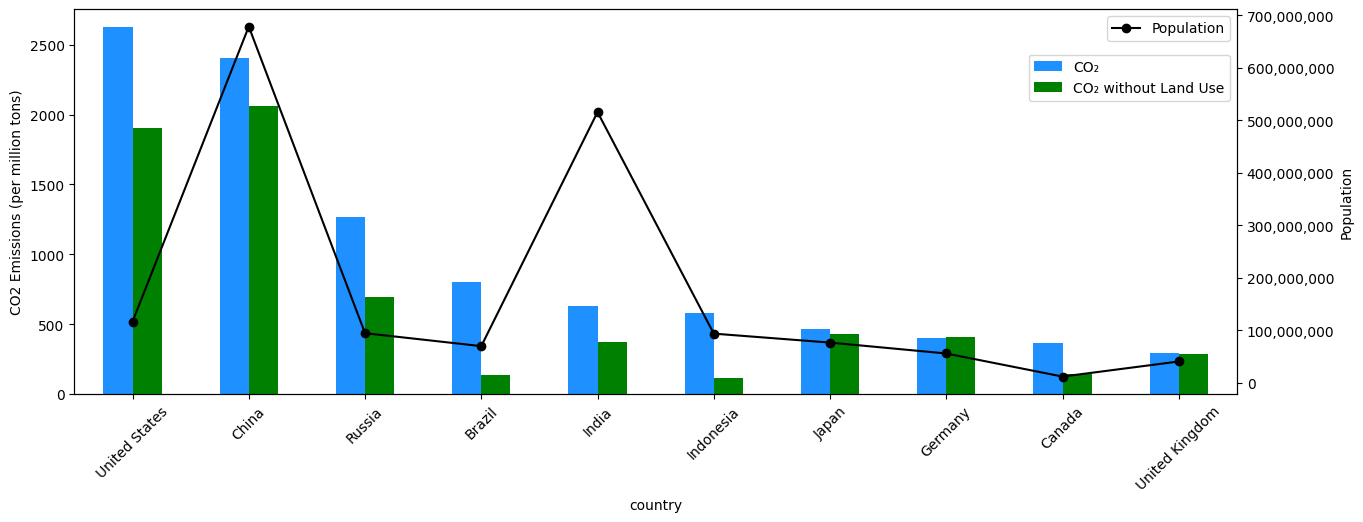

In [47]:
import matplotlib.ticker as tck
def comma_formatter(x, pos):
    return "{:,}".format(int(x))

fig, ax1 = plt.subplots(figsize=(15,5))
df_top_country.plot(x="country",y=["co2","co2 without land_use"], \
    color=["dodgerblue","green"],rot=45, kind="bar", ax=ax1)
ax1.set_ylabel('CO2 Emissions (per million tons)')
ax2 = ax1.twinx()
df_top_country.plot(x="country",y="population",color="black",linestyle="-",marker="o",ax=ax2)
ax2.set_ylabel("Population")
ax2.yaxis.set_major_formatter(tck.FuncFormatter(comma_formatter))

# Legend Formats
legend1 = ax1.legend(['CO₂', 'CO₂ without Land Use'], loc='upper right')
legend2 = ax2.legend(['Population'], loc='upper right')
legend1.set_bbox_to_anchor((1.0, 0.9))
legend2.set_bbox_to_anchor((1.0, 1.0))
plt.show()

<h3> Getting Demographics by Continent </h3>

In [48]:
# Boolean mask to obtain data which is NaN at iso_code since they don't represent the country
nan_mask = df_demographics['iso_code'].isna()
df_continent = df_demographics[nan_mask].groupby('country')[demographics_values].mean()

# Continents Filter
cont_list = ['Africa', 'Asia', 'Europe', 'Oceania', 'North America', 'South America', 'World']
df_continent_f =df_continent.loc[cont_list]

# Further modifications
df_continent_f.reset_index(inplace=True)
df_continent_f = df_continent_f.rename(columns={"country":"continent"})
df_continent_f

,continent,population,gdp,co2,land_use_change_co2
0,Africa,2.900542e+08,NaN,180.638551,961.352866
1,Asia,1.558715e+09,NaN,2049.987276,1775.945267
2,Europe,4.514502e+08,NaN,1975.162511,800.258651
3,Oceania,1.137026e+07,NaN,78.535493,109.343105
4,North America,1.816647e+08,NaN,1780.201118,1175.945029
5,South America,1.109846e+08,NaN,162.748309,1063.710116
6,World,2.604209e+09,3.865245e+13,6385.772169,4316.805465


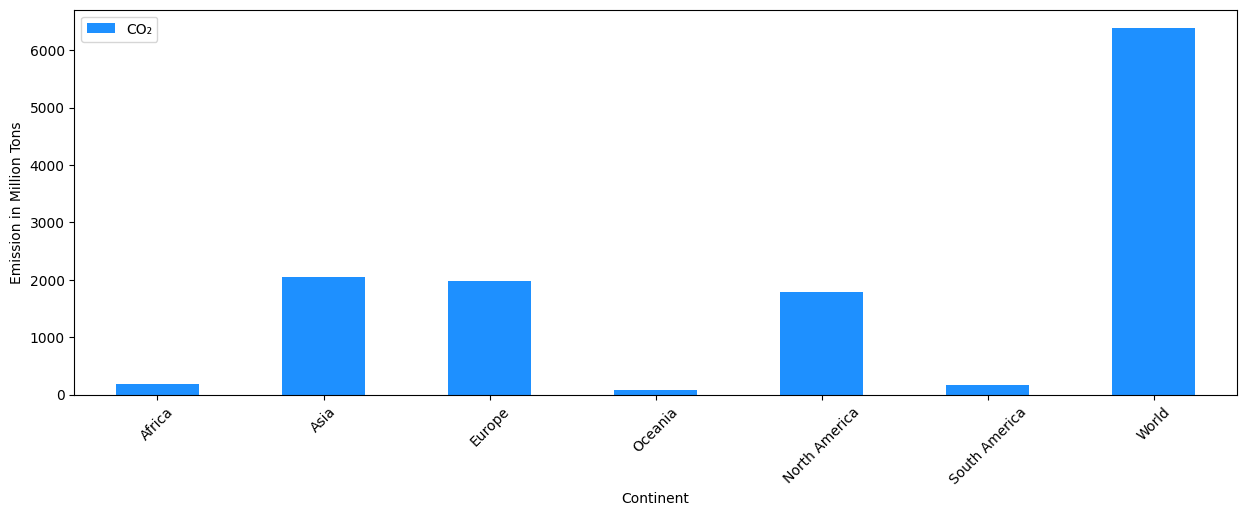

In [49]:
fig, ax = plt.subplots(figsize=(15,5))
df_continent_f.plot(x="continent", y="co2",kind="bar",rot=45, \
    ax=ax, color="dodgerblue")
ax.set_xlabel("Continent")
ax.set_ylabel("Emission in Million Tons")
ax.legend(["CO₂"])
plt.show()

<h3>Table 3: Grouping By Year</h3>
<p>based on checking the dataset structure, the rows represents by year per parameters of CO<sub>2</sub>. I will take the mean value of the emissions to compress the dataset, and simplify its findings. 

In [50]:
# Set year as index
df_demographics.set_index(["year"], inplace=True)

# Column with values to maintain
demographics_values = ["population","gdp","co2","land_use_change_co2"]
df_demo_yr = df_demographics.groupby("year")[demographics_values].mean()
df_demo_yr.reset_index(inplace=True)
df_demo_yr.shape


(272, 5)

In [51]:
# Rename co2 column based on the data definition
df_demo_yr = df_demo_yr.rename(columns={"co2":"co2 without land_use", \
    "index":"id"})

# Include land use change for calculations
df_demo_yr['co2'] = df_demo_yr['co2 without land_use'] + \
    df_demo_yr['land_use_change_co2']

# Dropping unnecessary columns
df_demo_yr = df_demo_yr.drop(['land_use_change_co2'],axis=1).copy()
df_demo_yr.head()

,year,population,gdp,co2 without land_use,co2
0,1750,8.043823e+07,NaN,1.650176,NaN
1,1751,NaN,NaN,1.650176,NaN
2,1752,NaN,NaN,1.650706,NaN
3,1753,NaN,NaN,1.650706,NaN
4,1754,NaN,NaN,1.651412,NaN


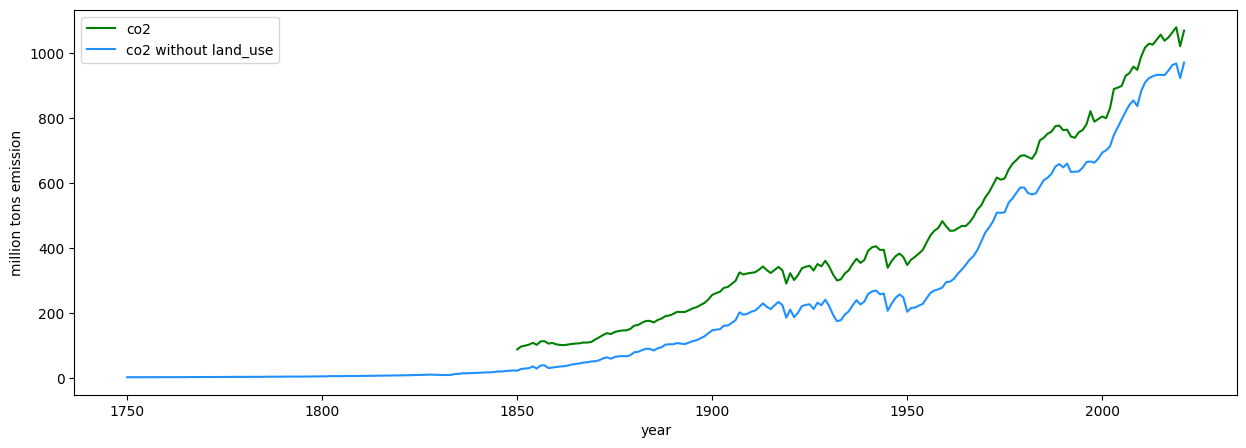

In [52]:
ax = df_demo_yr.plot(x="year",y="co2",figsize=(15,5),color='green')
df_demo_yr.plot(ax=ax,x="year", y="co2 without land_use",color='dodgerblue')
plt.ylabel("million tons emission")
plt.show()

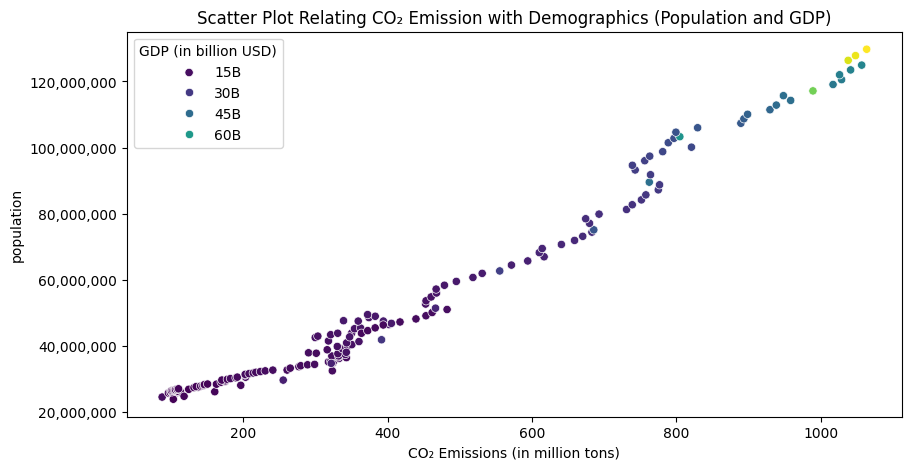

In [53]:
import matplotlib.ticker as tck
def comma_formatter(x, pos):
    return "{:,}".format(int(x))

plt.figure(figsize=(10,5))
scatter = sns.scatterplot(df_demo_yr,x="co2",y="population",hue="gdp",palette="viridis")
scatter.yaxis.set_major_formatter(tck.FuncFormatter(comma_formatter))

legend_labels = ['15B', '30B', '45B', '60B']
ax = plt.gca()
ax.legend(legend_labels, title="GDP (in billion USD)")


plt.title("Scatter Plot Relating CO₂ Emission with Demographics (Population and GDP)")
plt.xlabel("CO₂ Emissions (in million tons)")
plt.show()

<h3> Table 4: Temperature Change Table</h3>

In [54]:
#  Grouping by Temperature Change List per Country
temp_change_list = ['temperature_change_from_co2','temperature_change_from_ghg',\
    'temperature_change_from_ch4','temperature_change_from_n2o']

df_temp = df_temp.groupby(['country','iso_code'])[temp_change_list].mean()
df_temp.reset_index(inplace=True)
df_temp.head()

,country,iso_code,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_n2o
0,Afghanistan,AFG,0.000023,0.000415,0.000058,0.0
1,Aland Islands,ALA,NaN,NaN,NaN,NaN
2,Albania,ALB,0.000000,0.000000,0.000000,0.0
3,Algeria,DZA,0.000322,0.001275,0.000889,0.0
4,American Samoa,ASM,NaN,NaN,NaN,NaN


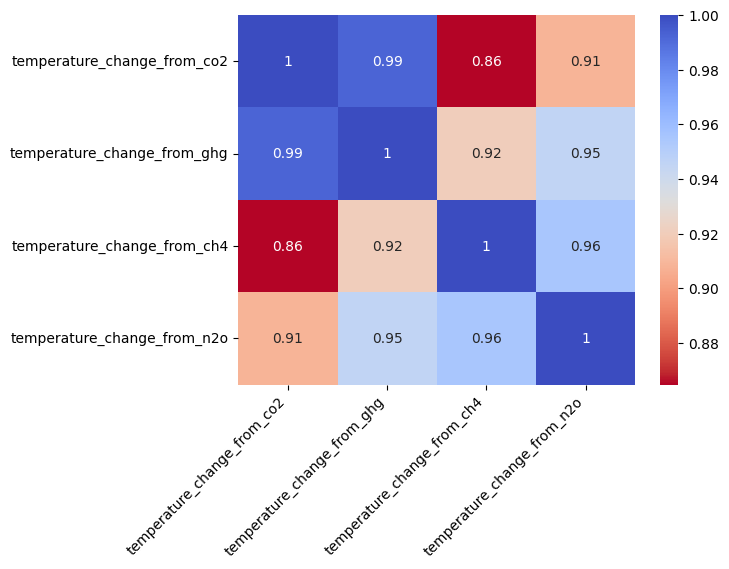

In [55]:
df_corr = df_temp.drop(['country','iso_code'],axis=1).corr()
sns.heatmap(df_corr,cmap='coolwarm_r',annot=True)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [56]:
df_temp.reset_index(inplace=True)

<h3>Table 5: Chemical Composition by Year Table </h3>

In [57]:
df_chem_yr = df_chem.groupby('year')[['methane','nitrous_oxide']].mean()
df_chem_yr = df_chem_yr.dropna(subset=['methane','nitrous_oxide'])
df_chem_yr.head()


,methane,nitrous_oxide
year,,
1990,132.668195,47.276049
1991,132.863512,46.964537
1992,132.371610,46.768098
1993,132.827317,46.433805
1994,133.710146,48.219951


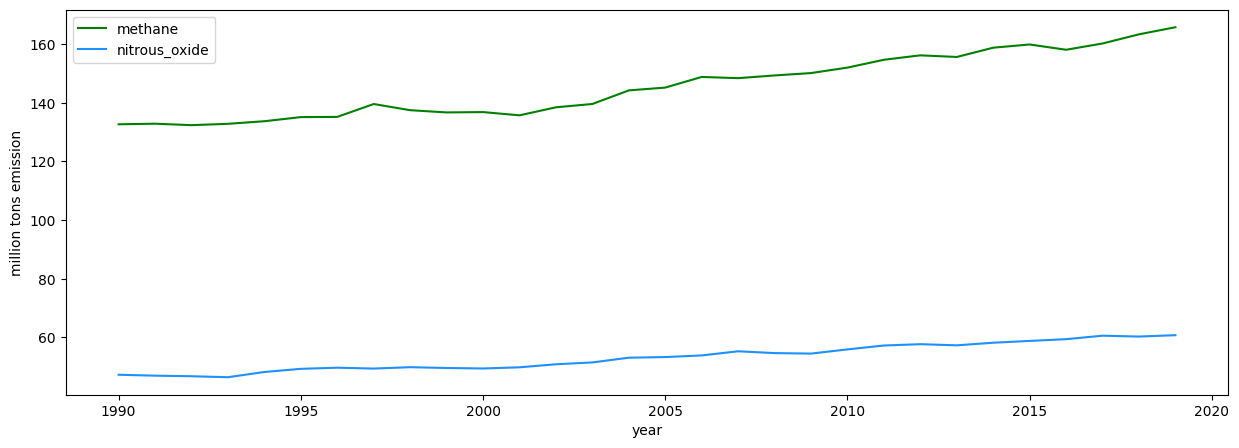

In [58]:
ax = df_chem_yr.plot(use_index=True,y="methane",figsize=(15,5),color='green')
df_chem_yr.plot(ax=ax,use_index=True, y="nitrous_oxide",color='dodgerblue')
plt.ylabel("million tons emission")
plt.show()

In [59]:
df_chem_yr.reset_index(inplace=True)

<h3>Table 6: Chemical Composition by Country Table </h3>

In [60]:
df_chem_country = df_chem.groupby(['country','iso_code'])[['methane','nitrous_oxide']].mean()
df_chem_country = df_chem_country.dropna(subset=['methane','nitrous_oxide']).reset_index()
df_chem_country.head()

,country,iso_code,methane,nitrous_oxide
0,Afghanistan,AFG,11.642333,3.885667
1,Albania,ALB,3.389667,1.198000
2,Algeria,DZA,76.839000,7.982333
3,Andorra,AND,0.039333,0.000000
4,Angola,AGO,37.713000,22.278667


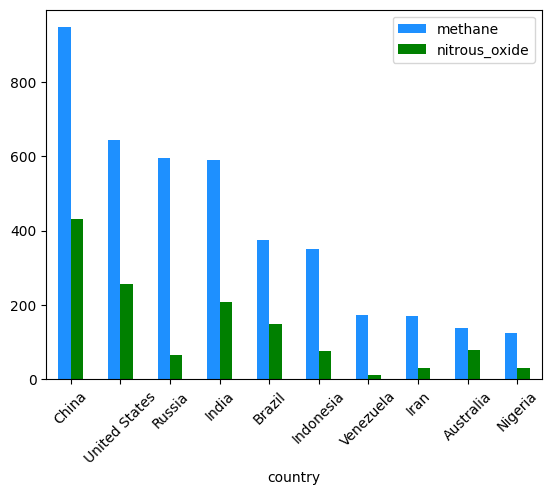

In [61]:
df_chem_sorted = df_chem_country.sort_values(by=['methane','nitrous_oxide'], ascending=False)
df_chem_top10 = df_chem_sorted.head(10)
df_chem_top10.plot(x="country",y=["methane","nitrous_oxide"], \
    color=["dodgerblue","green"],rot=45, kind="bar")
plt.show()

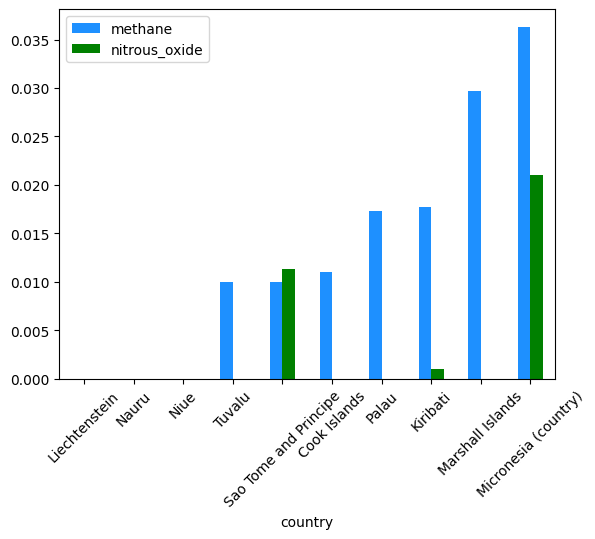

In [62]:
df_chem_least_srt = df_chem_country.sort_values(by=['methane','nitrous_oxide'])
df_chem_least10= df_chem_least_srt.head(10)
df_chem_least10.plot(x="country",y=["methane","nitrous_oxide"], \
    color=["dodgerblue","green"],rot=45, kind="bar")
plt.show()


<h3>Saving the processed dataset</h3>

In [63]:
# Sources Table
df_sources.to_csv("clean_data/emission_sources.csv",index=False)

# Demographics Table
df_demo_country.to_csv("clean_data/demo_country.csv",index=False)
df_demo_yr.to_csv("clean_data/demo_year.csv",index=False)
df_continent_f.to_csv("clean_data/demo_continent.csv",index=False)

#  Temperature Change by Country
df_temp.to_csv("clean_data/temperature_change_emissions.csv",index=False)

# Chemical Composition Table
df_chem_country.to_csv("clean_data/chem_composition_country.csv",index=False)
df_chem_yr.to_csv("clean_data/chem_composition_yr.csv",index=False)